In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

binary_warped.shape: (720, 1280)


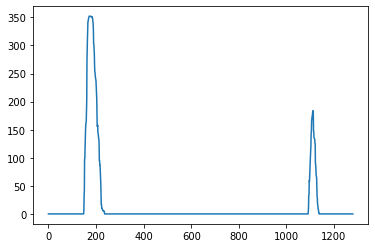

In [110]:
image_name = "intermediate_images/test5-warped-binary.jpg"
binary_warped = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE) # IMREAD_GRAYSCALE needed b/c of: https://stackoverflow.com/questions/18870603/in-opencv-python-why-am-i-getting-3-channel-images-from-a-grayscale-image
print("binary_warped.shape: {}".format(binary_warped.shape))
binary_warped_top_half = binary_warped[binary_warped.shape[0]//2:,:]

histogram = np.sum(binary_warped_top_half, axis=0)
plt.plot(histogram)

In [68]:

midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
print("histo shape: {}".format(histogram.shape))
max_val = np.argmax(histogram[:][0])
print("max: {}".format(max_val))
print("midpoint: {}, leftx_base: {}, rightx_base: {}".format(midpoint, leftx_base, rightx_base))

histo shape: (1280,)
max: 0
midpoint: 640, leftx_base: 171, rightx_base: 1112


## Split histogram into individual lanes

In [69]:

# Create an output image to draw on and visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

## Set up windows and window hyperparameters


In [70]:
# HYPERPARAMETERS
# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50

# Set height of windows - based on nwindows above and image shape
window_height = np.int(binary_warped_top_half.shape[0]//nwindows)
    
# Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
# Returns a row_major tuple of: (y_coords, x_coords)
nonzero = binary_warped_top_half.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated later for each window in nwindows
leftx_current = leftx_base
rightx_current = rightx_base

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

In [31]:
print("binary_warped_top_half.shape: {}".format(binary_warped_top_half.shape))
print(len(binary_warped_top_half.nonzero()[0]))


binary_warped_top_half.shape: (360, 1280)
21038


## Iterate through nwindows to track curvature

- Loop through each window in `nwindows`
- Find the boundaries of our current window. This is based on a combination of the current window's starting point (`leftx_current` and `rightx_current`), as well as the `margin` you set in the hyperparameters.
- Use `cv2.rectangle` to draw these window boundaries onto our visualization image out_img. This is required for the quiz, but you can skip this step in practice if you don't need to visualize where the windows are.
- Now that we know the boundaries of our window, find out which activated pixels from `nonzeroy` and `nonzerox` above actually fall into the window.
- Append these to our lists `left_lane_inds` and `right_lane_inds`.
- If the number of pixels you found in Step 4 are greater than your hyperparameter minpix, re-center our window (i.e. `leftx_current` or `rightx_current`) based on the mean position of these pixels.

binary_warped_top_half.shape: (360, 1280)
left_lane_bottom_left: (71, 720), left_lane_top_right: (271, 680)


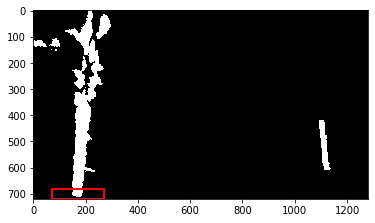

In [71]:
# Experiment with a single window

print("binary_warped_top_half.shape: {}".format(binary_warped_top_half.shape))
window = 9
shift_y = binary_warped_top_half.shape[0]

left_lane_bottom_left_pt_y = int(window * window_height) + shift_y
left_lane_bottom_left_pt_x = int(leftx_current - margin)  
left_lane_top_right_y = int((window * window_height) - window_height) + shift_y
left_lane_top_right_x = int(leftx_current + margin)

left_lane_bottom_left = (left_lane_bottom_left_pt_x, left_lane_bottom_left_pt_y)
left_lane_top_right = (left_lane_top_right_x, left_lane_top_right_y)

print("left_lane_bottom_left: {}, left_lane_top_right: {}".format(left_lane_bottom_left, left_lane_top_right))
cv2.rectangle(out_img, left_lane_bottom_left, left_lane_top_right, 255, 5)
plt.imshow(out_img)

In [72]:
# Helper function to find out which activated 
# pixels from nonzeroy and nonzerox above actually fall into the window.
def get_activated_window(pt1, pt2, nonzero_pts):

    # find min x coord
    min_x = min(pt1[0], pt2[0])
    
    # find max x coord
    max_x = max(pt1[0], pt2[0])
    
    # find min y coord
    min_y = min(pt1[1], pt2[1])
    
    # find max y coord
    max_y = max(pt1[1], pt2[1])

    # return filtered nonzero tuple where points fall within window
    nonzero_filtered = [nonzero_pt for nonzero_pt in np.transpose(nonzero_pts) 
                        if (nonzero_pt[0] >= min_y and 
                            nonzero_pt[0] <= max_y and
                            nonzero_pt[1] >= min_x and
                            nonzero_pt[1] <= max_x) ]
    
    # print("min_x: {} max_x: {} min_y: {} max_y: {}".format(min_x, max_x, min_y, max_y))
                                     
    return nonzero_filtered


In [73]:
def get_updated_window_center(
        current_window_center,
        pt1, 
        pt2, 
        activated,
        is_left):
    
    if len(activated) < minpix:
        return current_window_center
        
    # Loop over all the coords in activated and average the X coord 
    x_activated = [pt[1] for pt in activated]
    new_base = np.int(np.mean(x_activated))
    
    if is_left:
        print("changing left window center from {} -> {}".format(current_window_center, new_base))

        return new_base
    else:
        print("changing right window center from {} -> {}".format(current_window_center, new_base))

        return new_base
    
    

len(activated_left_lane): 1143
len(activated_right_lane): 0
changing left window center from 191 -> 169
left_lane_bottom_left: (91, 680) left_lane_top_right: (291, 720)
right_lane_bottom_left: (1002, 680) right_lane_top_right: (1202, 720)
len(activated_left_lane): 1644
len(activated_right_lane): 0
changing left window center from 169 -> 170
left_lane_bottom_left: (69, 640) left_lane_top_right: (269, 680)
right_lane_bottom_left: (1002, 640) right_lane_top_right: (1202, 680)
len(activated_left_lane): 2118
len(activated_right_lane): 248
changing left window center from 170 -> 181
changing right window center from 1102 -> 1122
left_lane_bottom_left: (70, 600) left_lane_top_right: (270, 640)
right_lane_bottom_left: (1002, 600) right_lane_top_right: (1202, 640)
len(activated_left_lane): 1937
len(activated_right_lane): 954
changing left window center from 181 -> 177
changing right window center from 1122 -> 1118
left_lane_bottom_left: (81, 560) left_lane_top_right: (281, 600)
right_lane_botto

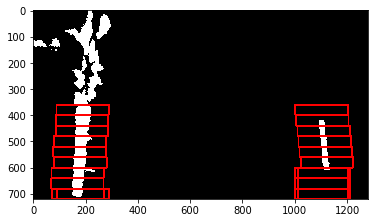

In [80]:
# Create empty lists to receive left and right lane pixel coords
left_lane_coords = []
right_lane_coords = []

shift_y = binary_warped_top_half.shape[0]
for window in reversed(range(nwindows)):
    
    # this is the "bottom" in the reference frame of the image coord system, but 
    # the "top" if you're looking at it in the (flipped) screen coord system.
    win_y_bottom = window * window_height + shift_y
    
    # conversely, this is the "top" in the reference frame of the image coord system
    win_y_top = (window+1) * window_height + shift_y
    
    # Calculate left left x coords
    left_lane_bottom_left_pt_x = int(leftx_current - margin)  
    left_lane_top_right_x = int(leftx_current + margin)

    # Calculate left lane rectangle points
    left_lane_bottom_left = (left_lane_bottom_left_pt_x, win_y_bottom)
    left_lane_top_right = (left_lane_top_right_x, win_y_top)
    
    # Calculate right light x coords
    right_lane_bottom_left_pt_x = int(rightx_current - margin)  
    right_lane_top_right_x = int(rightx_current + margin)

    # Calculate right lane rectangle points
    right_lane_bottom_left = (right_lane_bottom_left_pt_x, win_y_bottom)
    right_lane_top_right = (right_lane_top_right_x, win_y_top)
    
    # Now that we know the boundaries of our window, find out which activated 
    # pixels from nonzeroy and nonzerox above actually fall into the window.
    activated_left_lane = get_activated_window(
        left_lane_bottom_left, 
        left_lane_top_right, 
        binary_warped.nonzero())
    print("len(activated_left_lane): {}".format(len(activated_left_lane)))
    
    activated_right_lane = get_activated_window(
        right_lane_bottom_left, 
        right_lane_top_right, 
        binary_warped.nonzero())
    print("len(activated_right_lane): {}".format(len(activated_right_lane)))
    
    # Append these to our lists left_lane_inds and right_lane_inds.
    left_lane_coords += activated_left_lane
    right_lane_coords += activated_right_lane
    
    # If the number of pixels you found in Step 4 are greater than your 
    # hyperparameter minpix, re-center our window (i.e. leftx_current or rightx_current) based on the mean position of these pixels.
    leftx_current = get_updated_window_center(
        leftx_current,
        left_lane_bottom_left, 
        left_lane_top_right, 
        activated_left_lane,
        is_left=True,
    )
    rightx_current = get_updated_window_center(
        rightx_current,
        right_lane_bottom_left, 
        right_lane_top_right, 
        activated_right_lane,
        is_left=False,
    )
    
    cv2.rectangle(out_img, left_lane_bottom_left, left_lane_top_right, 255, 5)
    cv2.rectangle(out_img, right_lane_bottom_left, right_lane_top_right, 255, 5)


    print("left_lane_bottom_left: {} left_lane_top_right: {}".format(left_lane_bottom_left, left_lane_top_right))
    print("right_lane_bottom_left: {} right_lane_top_right: {}".format(right_lane_bottom_left, right_lane_top_right))

plt.imshow(out_img)

## Fit a polynomial


In [82]:
# Extract left and right line pixel positions
leftx = [pt[1] for pt in left_lane_coords]
lefty = [pt[0] for pt in left_lane_coords]
rightx = [pt[1] for pt in right_lane_coords]
righty = [pt[0] for pt in right_lane_coords]

In [90]:
z = np.polyfit(leftx, lefty, 3)
print(z)
p = np.poly1d(z)
print(p)

[ 1.33482178e-04 -4.40450354e-02  1.28229174e-02  1.17097131e+03]
           3           2
0.0001335 x - 0.04405 x + 0.01282 x + 1171


In [88]:
xp = np.linspace(0, 1280, 100)

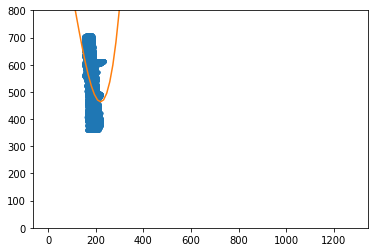

In [98]:
plt.ylim(0,800)
_ = plt.plot(leftx, lefty, '.', xp, p(xp))

In [106]:
def fit_polynomial(binary_warped):
   
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(leftx, lefty, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[leftx, lefty] = [255, 0, 0]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')

    return out_img

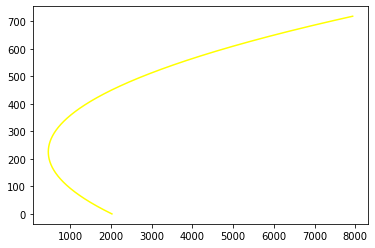

In [107]:
fit_polynomial_result = fit_polynomial(binary_warped)

## Using Quiz example

In [108]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [113]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    left_points = (left_fitx, ploty)
    right_points = (right_fitx, ploty)

    return left_points, right_points, out_img


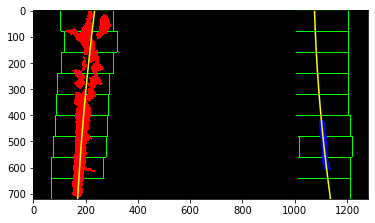

In [114]:
left_points, right_points, out_img = fit_polynomial(binary_warped)

plt.imshow(out_img)

In [112]:
print(binary_warped.shape)

(720, 1280)


In [115]:
# from 3rd_Party_solns/miguelangel/advanced_lane_finding.ipynb
def draw_lane(img, warped_img, left_points, right_points, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = left_points[0]
    right_fitx = right_points[0]
    ploty = left_points[1]
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

In [ ]:
src_pts = np.array(
    [[490, 482], # top left
    [810, 482],  # top right
    [1250, 720], # bottom right
    [40, 720]],   # bottom left
    dtype = "float32"
)
dest_pts = np.array(
    [[0, 0],
    [1280, 0],
    [1250, 720],
    [40, 720]],
    dtype = "float32"
)
M_inverse = cv2.getPerspectiveTransform(dest_pts, src_pts)
img_lane = draw_lane(img, binary_warped, left_points, right_points, M_inverse)
